In [1]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import numpy as np
import cv2
import os

# 버전확인

In [3]:
import imageio
print("matplotlib version: ", mpl.__version__)
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("opencv version: ", cv2.__version__)
print("imageio version: ", imageio.__version__)

matplotlib version:  3.6.2
tensorflow version:  2.7.0
numpy version:  1.19.5
opencv version:  4.6.0
imageio version:  2.19.3


# 이미지 예측 로직

haarcascade_frontalface_default.xml가 같은 폴더에 있어야함

In [22]:
from tensorflow.keras.models import load_model
from imageio import mimsave as save_gif
from numpy import arange
import cv2
import os

class CelebrityPredictionModel:
    def __init__(self, base_dir=None) -> None:
        if base_dir:
            model_male_path = os.path.join(base_dir, "model_men.h5")
            mode_female_path = os.path.join(base_dir, "model_women.h5")
            face_detector_path = os.path.join(base_dir, "haarcascade_frontalface_default.xml")
        else:
            model_male_path = os.path.join(base_dir, "./model/model_men.h5")
            mode_female_path = os.path.join(base_dir, "./model/model_women.h5")
            face_detector_path = os.path.join(base_dir, "./model/haarcascade_frontalface_default.xml")
            
        self.__model_male = load_model(model_male_path)
        self.__model_female = load_model(mode_female_path)
        self.__face_detector = cv2.CascadeClassifier(face_detector_path)
        self.__male_celebrity = ['마동석', '문빈', '비', '손석구', '송강', '송강호', '유재석', '조우진', '지코', '차은우', '박보검', '김수현', '강동원', '정국', '김종국']
        self.__female_celebrity = ['나연', '박나래', '박은빈', '박진주', '에일리', '이국주', '제니', '주현영', '츄', '미주', '솔라', '민지', '장원영', '카즈하', '아이유']
    
    def __read_img(self, img_path):
        img = cv2.imread(img_path)
        if img is None:
            raise Exception("이미지를 불러오지 못했습니다.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    
    def __crop_face(self, img):
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        face = self.__face_detector.detectMultiScale(gray_img, 1.3, 5)
        if len(face) == 0:
            return False
        (x,y,w,h) = face[0]
        cropped = img[y: y+h, x: x+w]
        cropped = cv2.resize(cropped, (180,180))
        return cropped
    
    def predict_img(self, sex, img_path, top_n=5) -> list:
        '''
        성별과 이미지 경로를 입력받아 예측값을 반환합니다.
            Args:
                sex `int` : 성별을 나타내는 정수입니다. 0은 남성, 1은 여성입니다.
                img_path `str` : 이미지 경로입니다.
                top_n `int` : 예측값 중 상위 몇개를 반환할지 결정합니다.
            Returns:
                `list` : 확률 내림차순으로 정렬된 list형의 결과를 반환합니다. 얼굴이 검출되지 않았을 경우 False를 반환합니다.
                ex) [(확률1, 예측 연예인1), (확률2, 예측 연예인2), ...]
        '''
        # 성별에 따라 모델, 연예인 리스트 불러오기
        if sex == 0:
            model = self.__model_male
            celeb = self.__male_celebrity
        elif sex == 1:
            model = self.__model_female
            celeb = self.__female_celebrity
        else:
            raise Exception("성별 정보가 0 또는 1이 아닙니다.")

        # crop된 이미지 불러오기
        cropped = self.__crop_face(self.__read_img(img_path))
        if cropped is False:
            return []

        # 모델 예측
        predict_result = model.predict(cropped.reshape(1,180,180,3))[0]
        result = sorted([(round(predict_result[i], 5)*100, c) for i, c in enumerate(celeb)], reverse=True)

        # 상위 5개 반환
        return result[:top_n]

    def get_trasition_gif(self, from_img_path, to_img_path, gif_path) -> None:
        '''
        두 이미지를 입력받아 두 이미지 사이의 변화를 gif로 저장합니다.
            Args:
                from_img_path `str` : 변화를 시작할 이미지 경로입니다.
                to_img_path `str` : 변화를 끝낼 이미지 경로입니다.
                gif_path `str` : 저장할 gif 경로입니다.
            Returns:
                `None` : 반환값이 없습니다.
        '''
        # 얼굴 크롭하기
        cropped_from = self.__crop_face(self.__read_img(from_img_path))
        if cropped_from is False:
            return False
        cropped_to = self.__crop_face(self.__read_img(to_img_path))
        if cropped_to is False:
            return False
        
        # gif 만들기
        gif = []
        for i in arange(0, 1, 0.02):
            img = cv2.addWeighted(cropped_from, 1 - i, cropped_to, i, 0)
            gif.append(img)
            
        save_gif(gif_path, gif, fps=20)
        return None


In [23]:
predictor = CelebrityPredictionModel("./")

In [42]:
import matplotlib.pyplot as plt

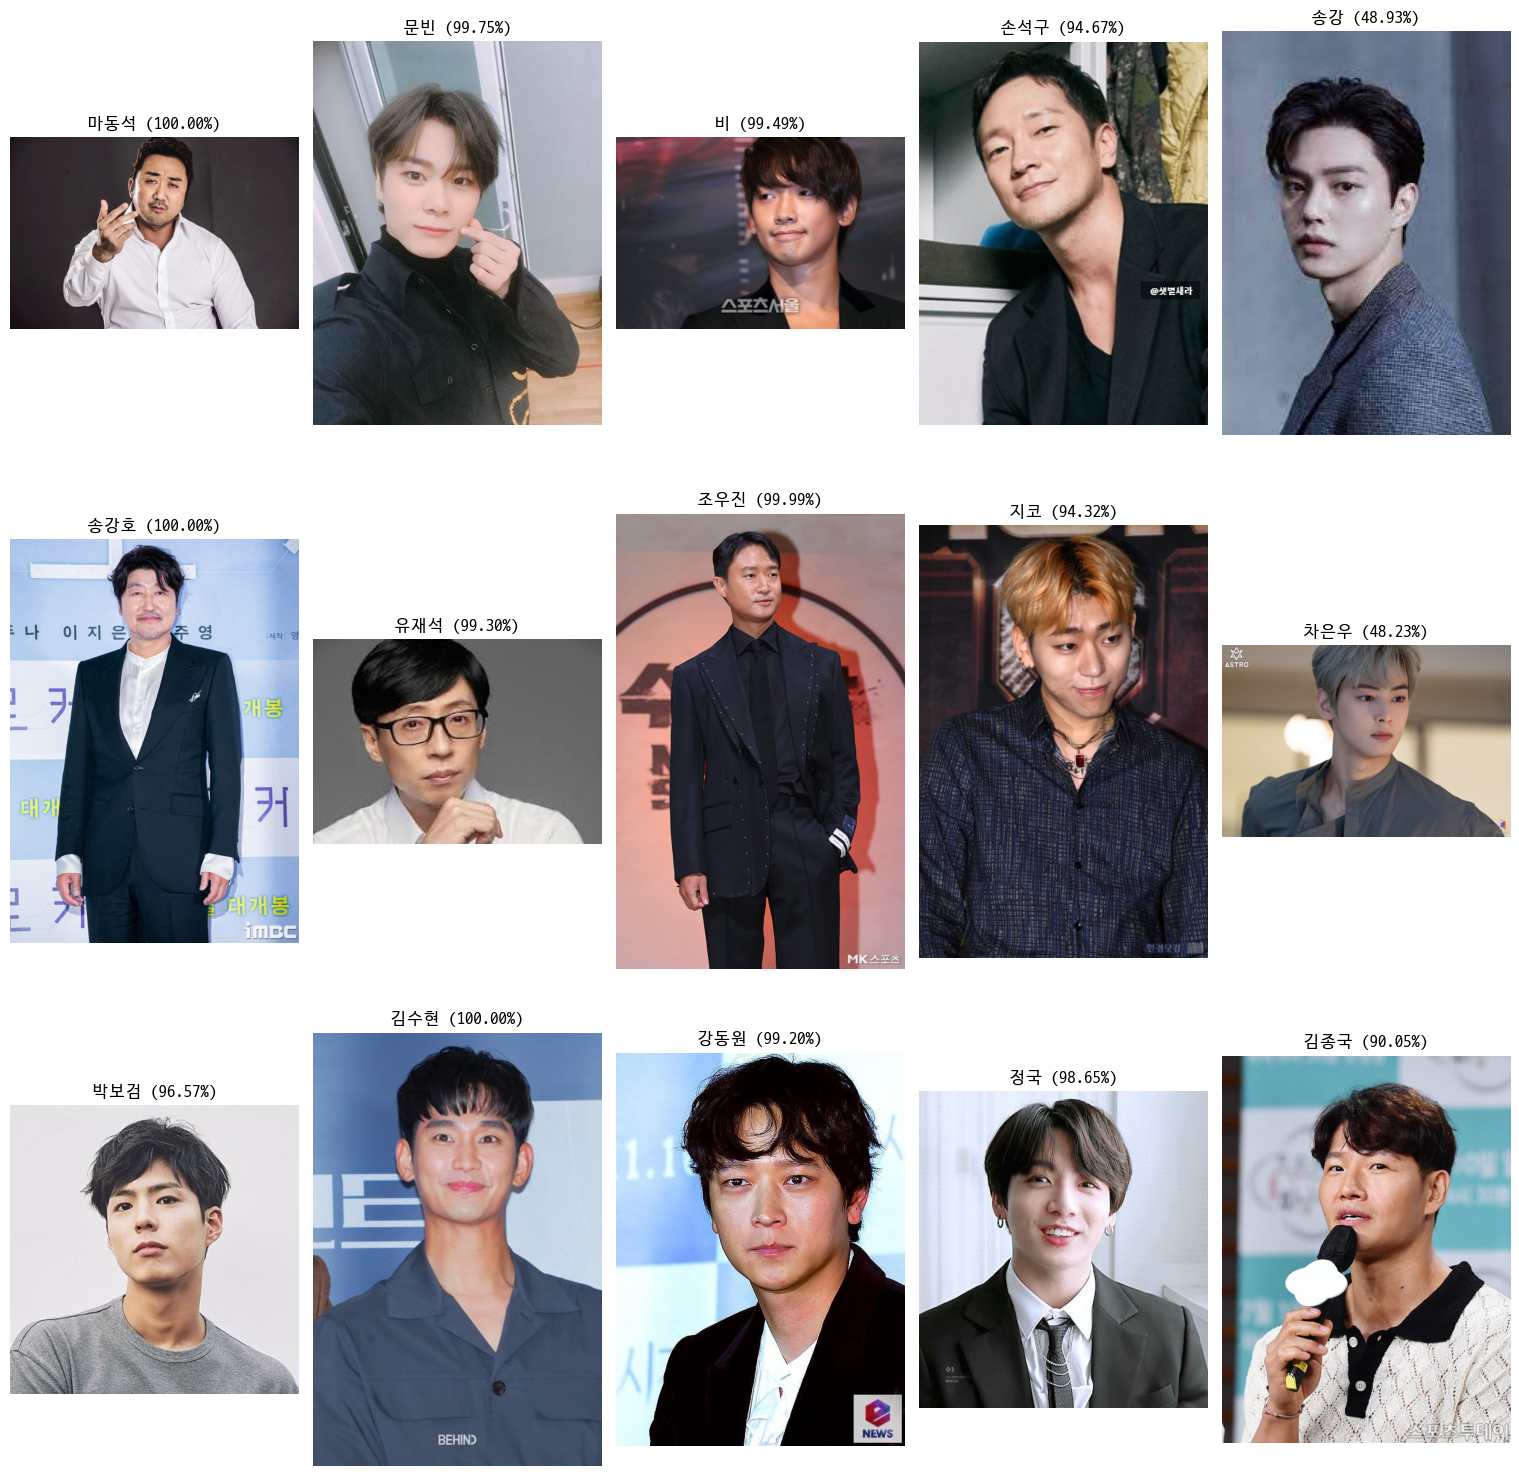

In [49]:
male_celebrity = ['마동석', '문빈', '비', '손석구', '송강', '송강호', '유재석', '조우진', '지코', '차은우', '박보검', '김수현', '강동원', '정국', '김종국']

plt.figure(figsize=(15, 15))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
plt.rc('font', family='D2Coding')

for imgs in range(15):
    img = cv2.imread("../test_imgs/male/%02d.jpg"%imgs)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    p, l = predictor.predict_img(0, "../test_imgs/male/%02d.jpg"%imgs)[0]
    plt.subplot(3, 5, imgs+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%s (%.2f%%)"%(l, p))
    

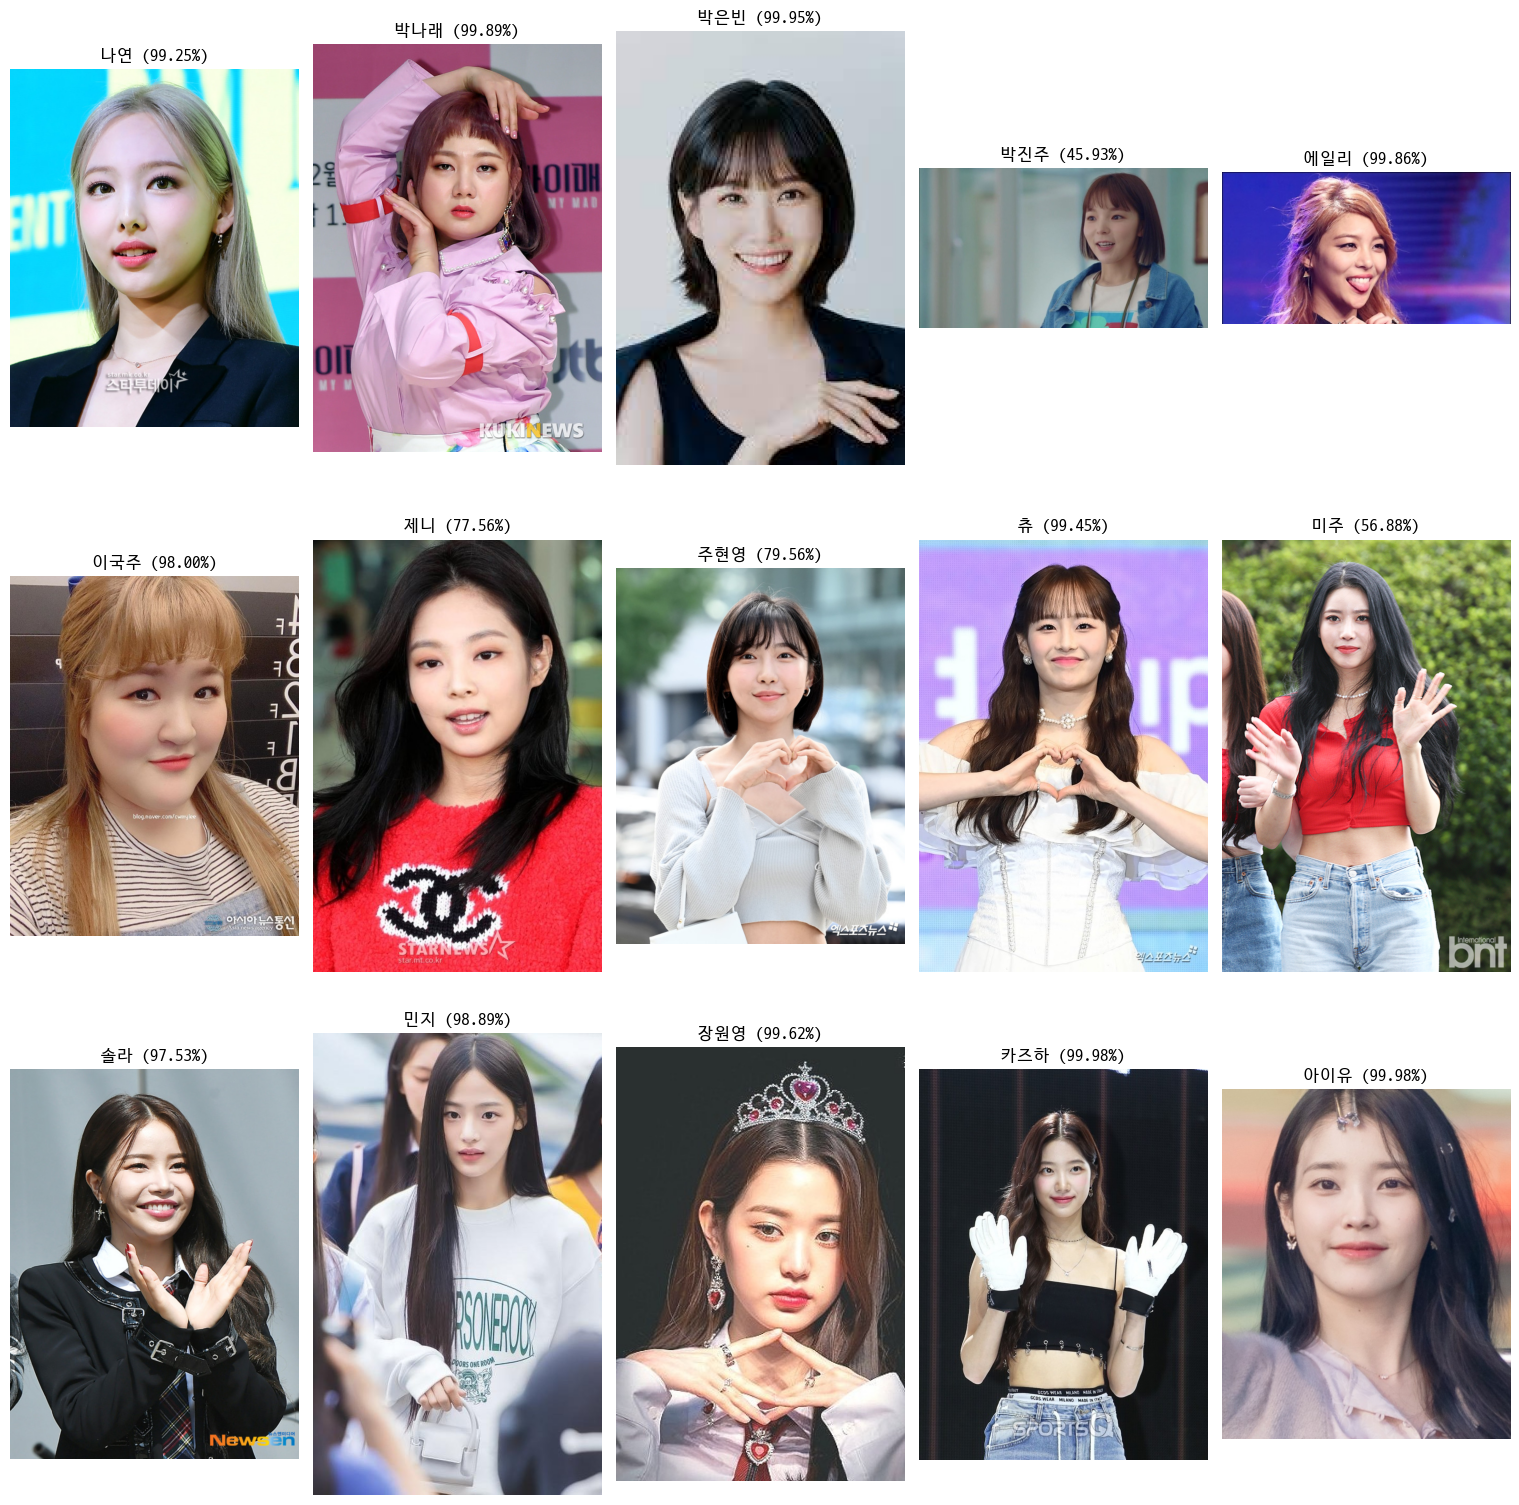

In [61]:
female_celebrity = ['나연', '박나래', '박은빈', '박진주', '에일리', '이국주', '제니', '주현영', '츄', '미주', '솔라', '민지', '장원영', '카즈하', '아이유']

plt.figure(figsize=(15, 15))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
plt.rc('font', family='D2Coding')

for imgs in range(15):
    # print(imgs)
    img = cv2.imread("../test_imgs/female/%02d.jpg"%imgs)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    p, l = predictor.predict_img(1, "../test_imgs/female/%02d.jpg"%imgs)[0]
    plt.subplot(3, 5, imgs+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%s (%.2f%%)"%(l, p))
    